In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from numpy.random import default_rng

In [ ]:
#!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-10f84b57-15e4-ef94-2fc3-af25b9357bae)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip "HW2_Part2_Dataset/tiny-imagenet-200.zip" -d "/content/drive/MyDrive/HW2_Part2_Dataset"

In [ ]:
!wget -P HW2_Part2_Dataset http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip "HW2_Part2_Dataset/tiny-imagenet-200.zip" -d "HW2_Part2_Dataset"

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, _type, choosen_classes, transform=None):
        self.transform = transform
        self.imgs_path = "/content/HW2_Part2_Dataset/tiny-imagenet-200/train"
        self.img_dim = (227, 227)
        self.img_dim2 = (192, 192)
        self.img_dim3 = (128, 128)
        self.images_path = []
        
        for _class_, folders in enumerate(os.listdir(self.imgs_path)):         
          if _class_ in choosen_classes:
            for idx, filename in enumerate(os.listdir(os.path.join(self.imgs_path,folders, 'images'))):
              if _type == 'Test' and idx < 50:
                self.images_path.append(os.path.join(self.imgs_path,folders,'images', filename))
              if _type == 'Train' and idx >= 50:
                self.images_path.append(os.path.join(self.imgs_path,folders,'images', filename))
    
  def __len__(self):
        return len(self.images_path)
    
    
  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        img = cv2.imread(self.images_path[idx])
        image = cv2.resize(img, self.img_dim)
        image2 = cv2.resize(img, self.img_dim2)
        image3 = cv2.resize(img, self.img_dim3)
              
        transform = transforms.ToTensor()
        image = transform(image)
        image2 = transform(image2)
        image3 = transform(image3)

        if self.transform:
            image = self.transform(image)
            image2 = self.transform(image2)
            image3 = self.transform(image3)
        return (image - 0.5) / 0.5, image2, image3
        

In [ ]:
class Net_Conv(nn.Module):
    def __init__(self, _type):
        super(Net_Conv, self).__init__()
        if _type == 2:
          self.conv1 = nn.ConvTranspose2d(192, 128, kernel_size=3, stride=2, padding=11, output_padding=1)
        else:
          self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1, output_padding=0)
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='leaky_relu')
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='leaky_relu')
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv3.weight, mode='fan_in', nonlinearity='leaky_relu')        
        self.upconv1 = nn.ConvTranspose2d(128, 128, kernel_size=5, stride=2, padding=2, output_padding=1)
        nn.init.kaiming_normal_(self.upconv1.weight, mode='fan_in', nonlinearity='leaky_relu')      
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1)
        nn.init.kaiming_normal_(self.upconv2.weight, mode='fan_in', nonlinearity='leaky_relu')      
        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        nn.init.kaiming_normal_(self.upconv3.weight, mode='fan_in', nonlinearity='leaky_relu')       
        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1)
        nn.init.kaiming_normal_(self.upconv4.weight, mode='fan_in', nonlinearity='leaky_relu')
        self.upconv5 = nn.ConvTranspose2d(16, 3, kernel_size=5, stride=2, padding=2, output_padding=1)
        nn.init.kaiming_normal_(self.upconv5.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        x = F.leaky_relu(self.upconv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.upconv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.upconv3(x), negative_slope=0.2)
        x = F.leaky_relu(self.upconv4(x), negative_slope=0.2)
        x = self.upconv5(x)
        return x

In [ ]:
class Net_Fc(nn.Module):
    def __init__(self, _type):
        super(Net_Fc, self).__init__()
        if _type == 6:
          self.fc1 = nn.Linear(4096, 4096)  
        else:
          self.fc1 = nn.Linear(1000, 4096)
        nn.init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        self.fc2 = nn.Linear(4096, 4096)
        nn.init.normal_(self.fc2.weight, mean=0.0, std=0.01)
        self.fc3 = nn.Linear(4096, 4096)
        nn.init.normal_(self.fc3.weight, mean=0.0, std=0.01)
        
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1)
        nn.init.kaiming_normal_(self.upconv1.weight, mode='fan_in', nonlinearity='leaky_relu')      
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1)
        nn.init.kaiming_normal_(self.upconv2.weight, mode='fan_in', nonlinearity='leaky_relu')      
        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        nn.init.kaiming_normal_(self.upconv3.weight, mode='fan_in', nonlinearity='leaky_relu')       
        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1)
        nn.init.kaiming_normal_(self.upconv4.weight, mode='fan_in', nonlinearity='leaky_relu')
        self.upconv5 = nn.ConvTranspose2d(16, 3, kernel_size=5, stride=2, padding=2, output_padding=1)
        nn.init.kaiming_normal_(self.upconv5.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.2)
        x = x.reshape(x.size(0), 256, 4, 4)
        x = F.leaky_relu(self.upconv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.upconv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.upconv3(x), negative_slope=0.2)
        x = F.leaky_relu(self.upconv4(x), negative_slope=0.2)
        x = self.upconv5(x)
        return x

In [ ]:
original_model = models.alexnet(pretrained=True)
class AlexNetConv2(nn.Module):
    def __init__(self):
        super(AlexNetConv2, self).__init__()
        self.features = nn.Sequential(*list(original_model.features.children())[:-7])
    def forward(self, x):
        x = self.features(x)
        return x

class AlexNetConv5(nn.Module):
    def __init__(self):
        super(AlexNetConv5, self).__init__()
        self.features = nn.Sequential(*list(original_model.features.children())[:])
    def forward(self, x):
        x = self.features(x)
        return x

class AlexNetFc6(nn.Module):
    def __init__(self):
        super(AlexNetFc6, self).__init__()
        self.features = original_model.features
        self.avgpool = original_model.avgpool
        self.classifier = nn.Sequential(*list(original_model.classifier.children())[:-4])
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

alexNetConv2 = AlexNetConv2()
alexNetConv5 = AlexNetConv5()
alexNetFc6 = AlexNetFc6()
alexNetFc8 = original_model

alexNetConv2 = alexNetConv2.to(device)
alexNetConv5 = alexNetConv5.to(device)
alexNetFc6 = alexNetFc6.to(device)
alexNetFc8 = alexNetFc8.to(device)

for param in alexNetConv2.parameters():
    param.requires_grad = False
for param in alexNetConv5.parameters():
    param.requires_grad = False
for param in alexNetFc6.parameters():
    param.requires_grad = False
for param in alexNetFc8.parameters():
    param.requires_grad = False

In [ ]:
rng = default_rng()
choosen_classes = rng.choice(200, size=20, replace=False)
print("choosen_classes : ", choosen_classes)

choosen_classes :  [ 84 136 188  54  92  44 160  89 102  97  18  70  76 121 124 122 134  31
  96 181]


In [ ]:
#choosen_classes = [84,136, 188, 54, 92, 44, 160, 89, 102, 97, 18, 70, 76, 121, 124, 122, 134, 31, 96, 181]
trainloader = torch.utils.data.DataLoader(CustomDataset('Train', choosen_classes), batch_size=64,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(CustomDataset('Test', choosen_classes), batch_size=20,
                                         shuffle=True, num_workers=2)

In [ ]:
def Train_model(optimizer, decoder, which_alexNet, k, name, num_epoch, dec_factro):
  loss_train = []
  loss_test = []
  PATH = '/content/drive/MyDrive/HW2_Part2_Dataset/Part2_'+ name + '.pth'
  for epoch in range(20):
      dataiter = iter(testloader)
      for i, data in enumerate(trainloader, 0):
          org_input = data[0].to(device)
          final_out = data[k].to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          with torch.no_grad():
            outputs_alexnet = which_alexNet(org_input)
          
          outputs = decoder(outputs_alexnet)
          loss = criterion(outputs, final_out)
          loss.backward()
          optimizer.step()
          # print statistics
          print('[%d, %5d] loss Train: %.8f' % (epoch + 1, i + 1, loss.item()))
          loss_train.append(loss.item())

          if i % 3 == 2:
            with torch.no_grad():  
              #running_loss_test = 0
              data_test = dataiter.next()  
              org_input_test = data_test[0].to(device)
              final_out_test = data_test[k].to(device)
              outputs_alexnet_test = which_alexNet(org_input_test)
              outputs_test = decoder(outputs_alexnet_test)
              loss_test_this_iter = criterion(outputs_test, final_out_test)
              running_loss_test = loss_test_this_iter.item()
              print('loss Test [%d, %5d] : %.8f' % (epoch + 1, i + 1, running_loss_test))
              loss_test.append(running_loss_test)
              
      #Change the Learning rate
      if epoch % num_epoch == num_epoch - 1:
        for g in optimizer.param_groups:
          g['lr'] *= dec_factro
      
      #Save Model
  torch.save(decoder.state_dict(), PATH)     
  return loss_train, loss_test

In [ ]:
decoder1 = Net_Conv(2)
decoder1 = decoder1.to(device)
optimizer1 = optim.Adam(decoder1.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.MSELoss()

In [ ]:
loss_train1, loss_test1 = Train_model(optimizer1, decoder1, alexNetConv2, 1, 'decoder1', 5, 0.5)

In [ ]:
decoder2 = Net_Conv(5)
decoder2 = decoder2.to(device)
optimizer2 = optim.Adam(decoder2.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
loss_train2, loss_test2 = Train_model(optimizer2, decoder2, alexNetConv5, 1, 'decoder2', 5, 0.5)

In [ ]:
decoder3 = Net_Fc(6)
decoder3 = decoder3.to(device)
optimizer3 = optim.Adam(decoder3.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
loss_train3, loss_test3 = Train_model(optimizer3, decoder3, alexNetFc6, 2, 'decoder3', 5, 0.5)

In [ ]:
decoder4 = Net_Fc(8)
decoder4 = decoder4.to(device)
optimizer4 = optim.Adam(decoder4.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
loss_train4, loss_test4 = Train_model(optimizer4, decoder4, alexNetFc8, 2, 'decoder4', 5, 0.5)

Part B

Text(0.5, 1.0, 'Test Loss Decoder 2')

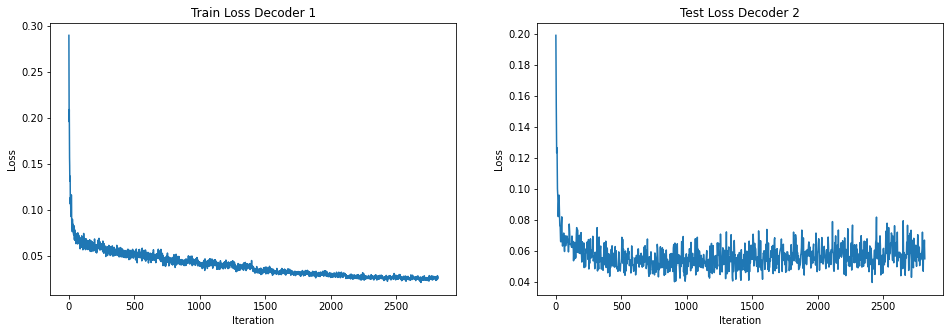

In [ ]:
f, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(range(1, 2821), loss_train1)
axarr[0].set_xlabel('Iteration')
axarr[0].set_ylabel('Loss')
axarr[0].set_title("Train Loss Decoder 1")

axarr[1].plot(range(1, 2821, 3), loss_test1)
axarr[1].set_xlabel('Iteration')
axarr[1].set_ylabel('Loss')
axarr[1].set_title("Test Loss Decoder 1")

Text(0.5, 1.0, 'Test Loss Decoder 2')

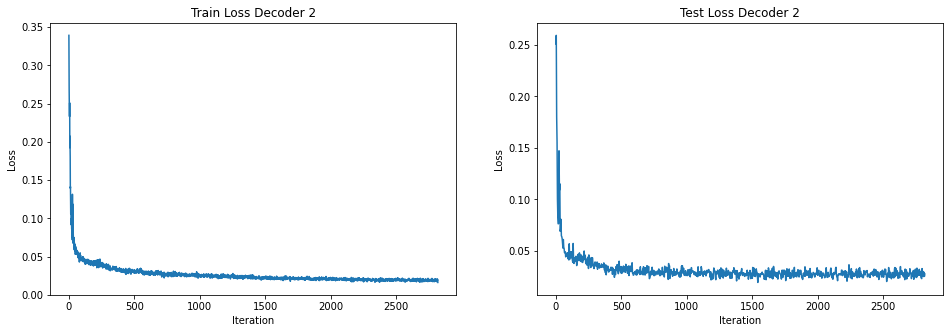

In [ ]:
f, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(range(1, 2821), loss_train2)
axarr[0].set_xlabel('Iteration')
axarr[0].set_ylabel('Loss')
axarr[0].set_title("Train Loss Decoder 2")

axarr[1].plot(range(1, 2821, 3), loss_test2)
axarr[1].set_xlabel('Iteration')
axarr[1].set_ylabel('Loss')
axarr[1].set_title("Test Loss Decoder 2")

Text(0.5, 1.0, 'Test Loss Decoder 3')

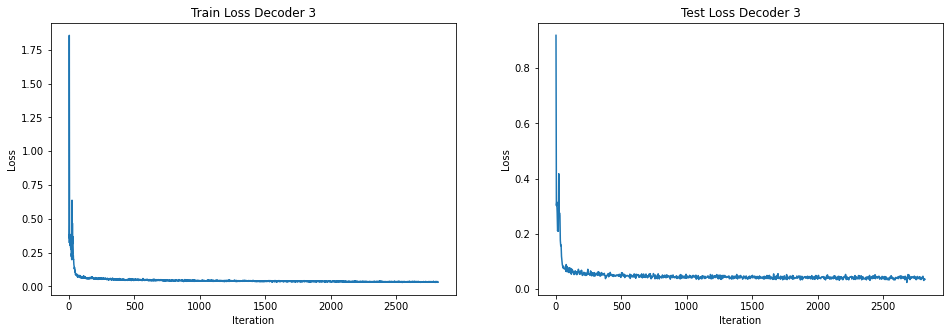

In [ ]:
f, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(range(1, 2821), loss_train3)
axarr[0].set_xlabel('Iteration')
axarr[0].set_ylabel('Loss')
axarr[0].set_title("Train Loss Decoder 3")

axarr[1].plot(range(1, 2821, 3), loss_test3)
axarr[1].set_xlabel('Iteration')
axarr[1].set_ylabel('Loss')
axarr[1].set_title("Test Loss Decoder 3")

Text(0.5, 1.0, 'Test Loss Decoder 4')

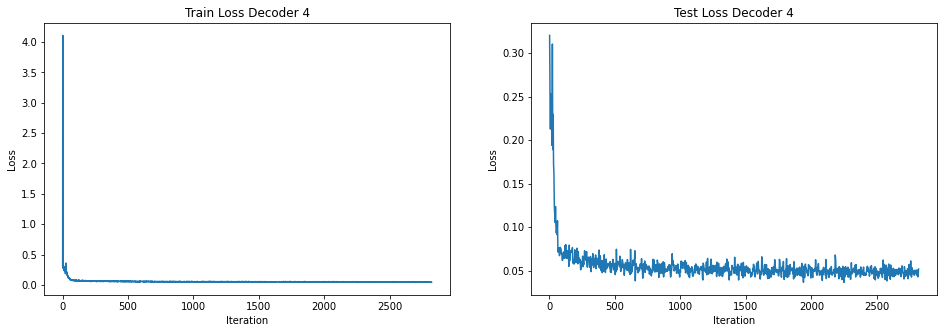

In [ ]:
f, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(range(1, 2821), loss_train4)
axarr[0].set_xlabel('Iteration')
axarr[0].set_ylabel('Loss')
axarr[0].set_title("Train Loss Decoder 4")

axarr[1].plot(range(1, 2821, 3), loss_test4)
axarr[1].set_xlabel('Iteration')
axarr[1].set_ylabel('Loss')
axarr[1].set_title("Test Loss Decoder 4")

Part C

In [ ]:
def _plot_result(decoder, which_alexNet, trainloader_part_c, testloader_part_c):    
    k = 0
    dataiter_train = iter(trainloader_part_c)
    dataiter_test = iter(testloader_part_c)
    f, axarr = plt.subplots(5,4, figsize=(18, 20))
    for i in range(5):
        with torch.no_grad():
          data_test = dataiter_test.next()
          outputs_alexnet_test = which_alexNet(data_test[0].to(device))
          outputs_test = decoder(outputs_alexnet_test)
          data_train = dataiter_train.next()
          outputs_alexnet_train = which_alexNet(data_train[0].to(device))
          outputs_train = decoder(outputs_alexnet_train)
        
        img_train = data_train[1][k].numpy().transpose([1,2,0])
        pred_train = outputs_train[k].cpu().numpy().transpose([1,2,0])
        img_test = data_test[1][k].numpy().transpose([1,2,0])
        pred_test = outputs_test[k].cpu().numpy().transpose([1,2,0])
        axarr[i,0].imshow(img_train)
        axarr[i,1].imshow(pred_train)
        axarr[i,2].imshow(img_test)
        axarr[i,3].imshow(pred_test)

In [ ]:
choosen_classes_part_c = [84, 136, 188, 54, 92]
print("choosen_classes : ", choosen_classes_part_c)

choosen_classes :  [84, 136, 188, 54, 92]


In [ ]:
trainloader_part_c = torch.utils.data.DataLoader(CustomDataset('Train', choosen_classes_part_c), batch_size=450,
                                          shuffle=False, num_workers=2)

testloader_part_c = torch.utils.data.DataLoader(CustomDataset('Test', choosen_classes_part_c), batch_size=50,
                                         shuffle=False, num_workers=2)

In [ ]:
decoder1 = Net_Conv(2)
decoder1.load_state_dict(torch.load('/content/drive/MyDrive/HW2_Part2_Dataset/Part2_decoder1.pth'))
decoder1 = decoder1.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


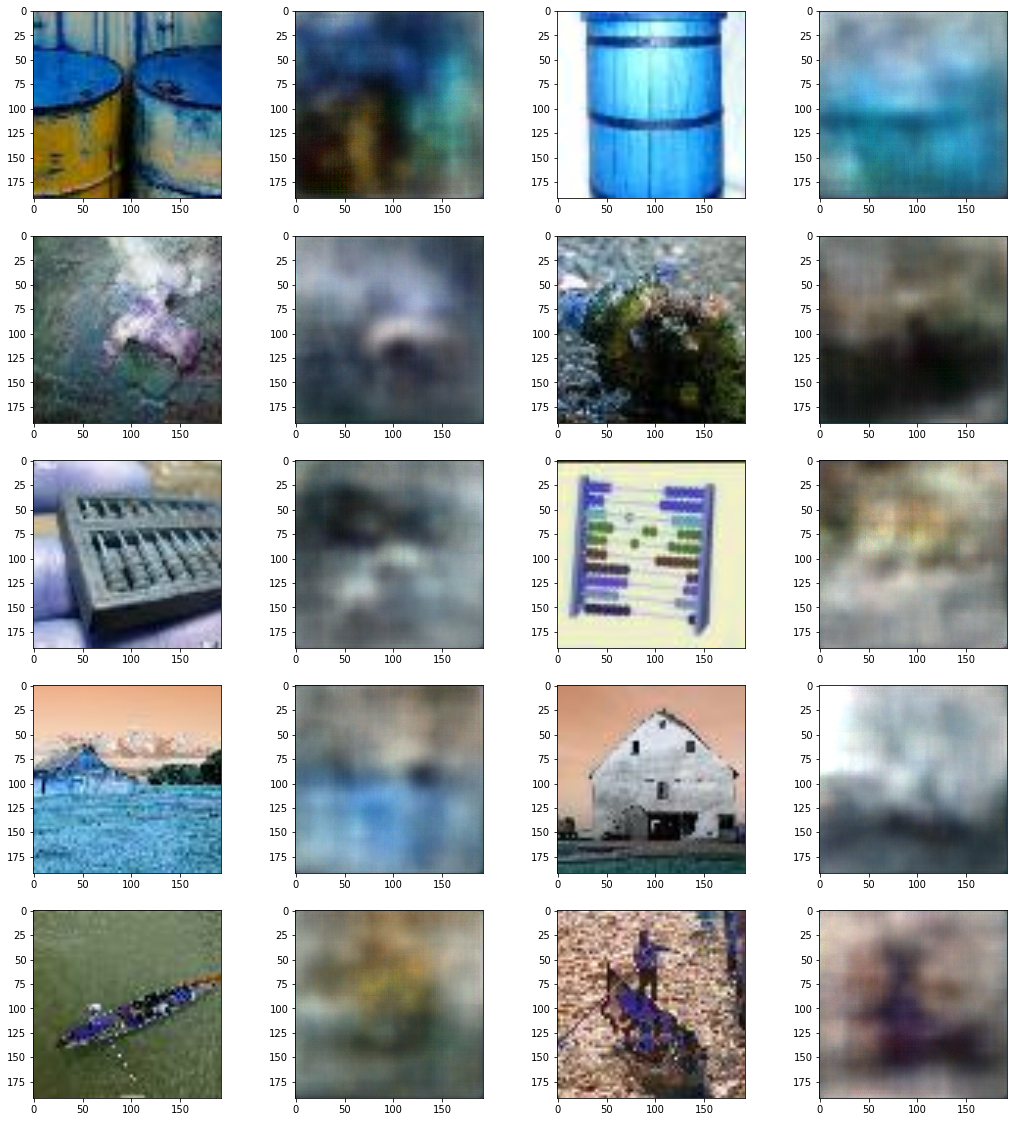

In [ ]:
_plot_result(decoder1, alexNetConv2, trainloader_part_c, testloader_part_c)

In [ ]:
decoder2 = Net_Conv(5)
decoder2.load_state_dict(torch.load('/content/drive/MyDrive/HW2_Part2_Dataset/Part2_decoder2.pth'))
decoder2 = decoder2.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


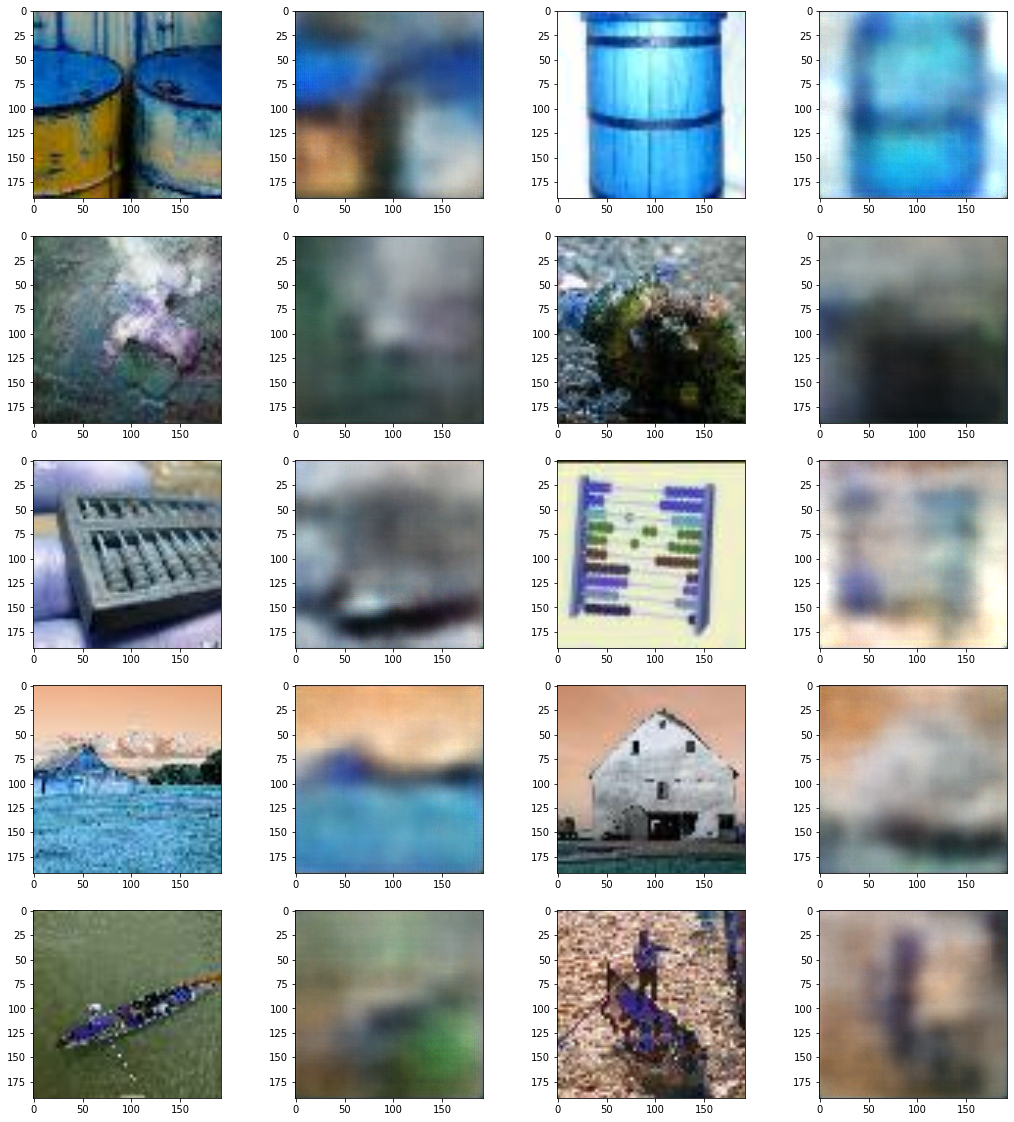

In [ ]:
_plot_result(decoder2, alexNetConv5, trainloader_part_c, testloader_part_c)

In [ ]:
decoder3 = Net_Fc(6)
decoder3.load_state_dict(torch.load('/content/drive/MyDrive/HW2_Part2_Dataset/Part2_decoder3.pth'))
decoder3 = decoder3.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


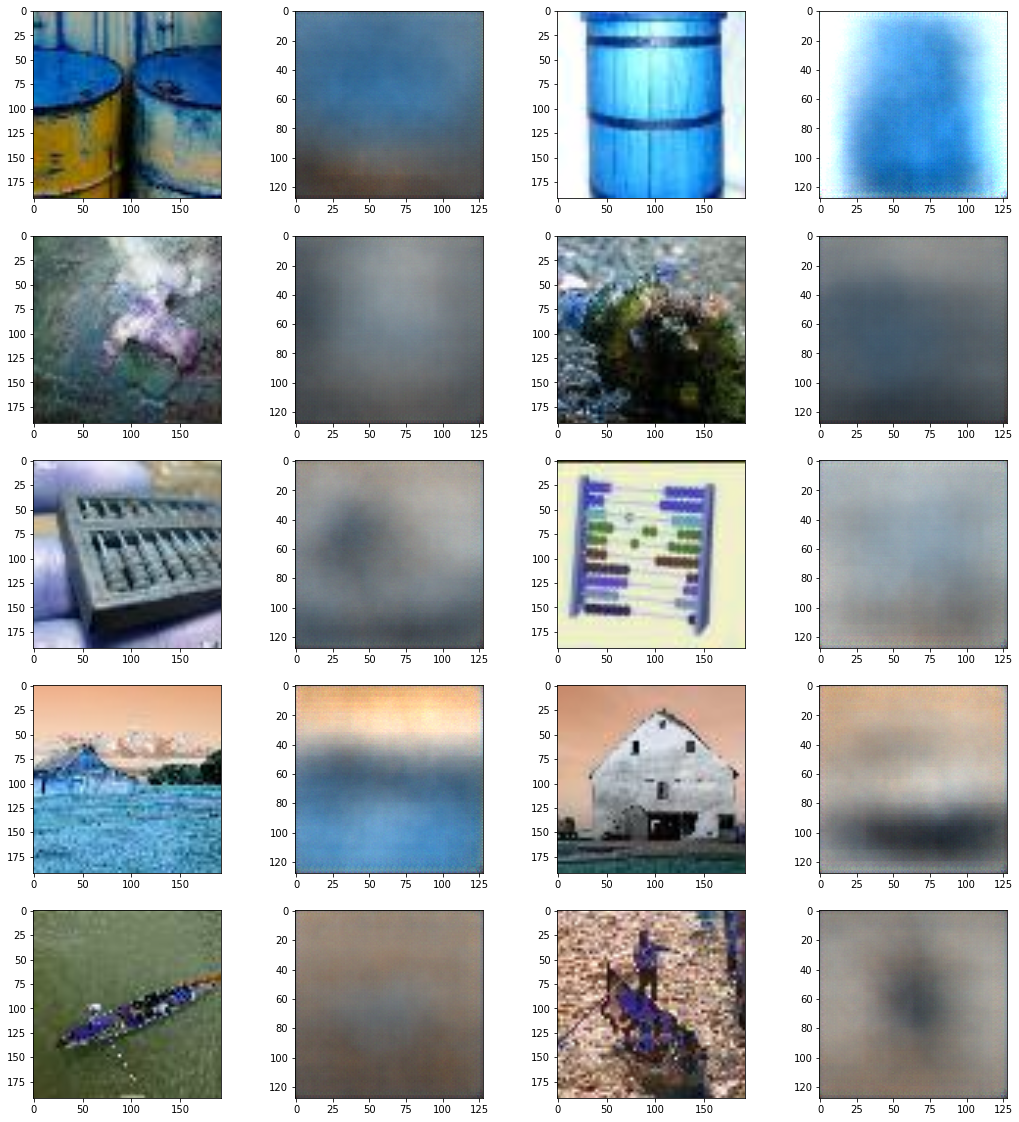

In [ ]:
_plot_result(decoder3, alexNetFc6, trainloader_part_c, testloader_part_c)

In [ ]:
decoder4 = Net_Fc(8)
decoder4.load_state_dict(torch.load('/content/drive/MyDrive/HW2_Part2_Dataset/Part2_decoder4.pth'))
decoder4 = decoder4.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


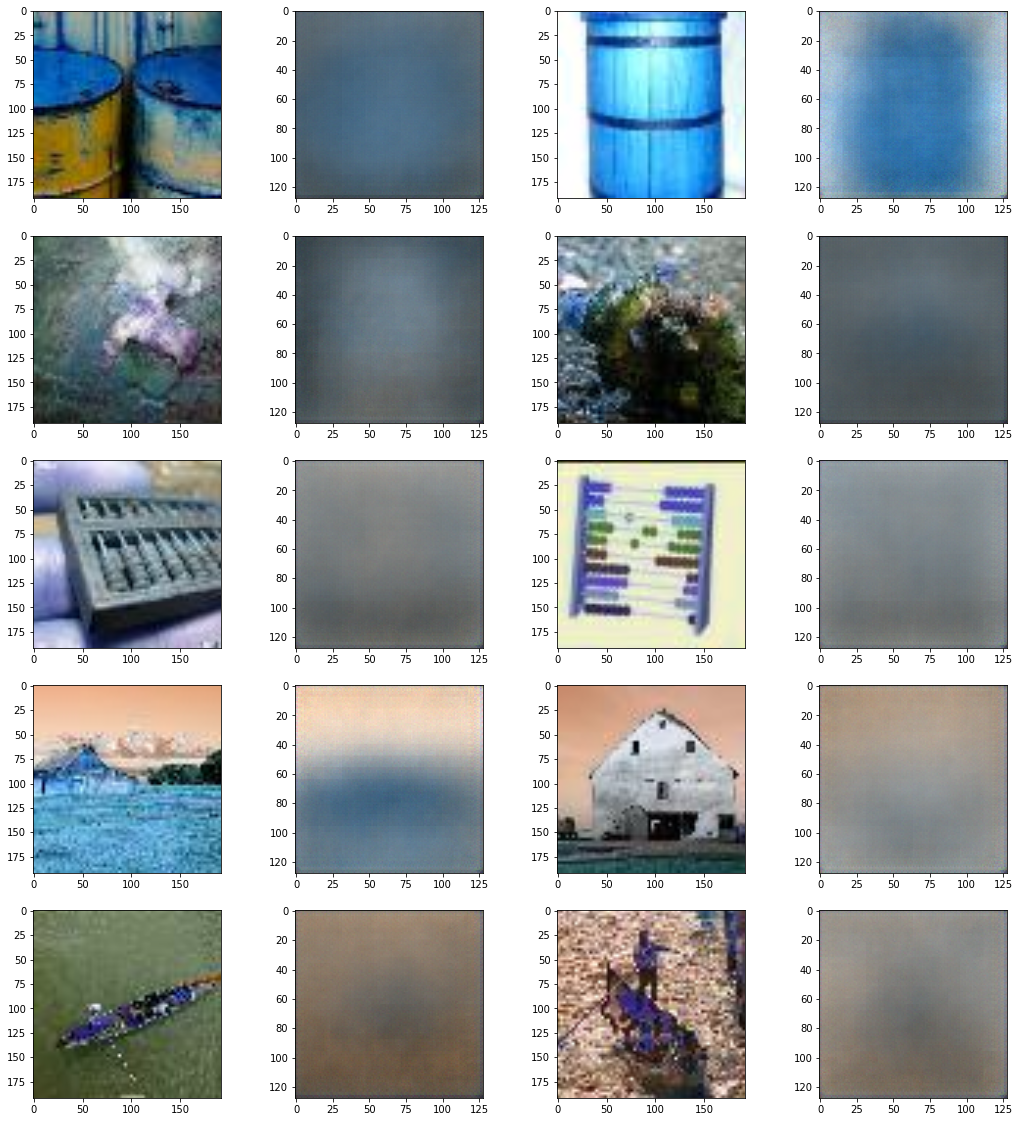

In [ ]:
_plot_result(decoder4, alexNetFc8, trainloader_part_c, testloader_part_c)